### Load Packages

In [38]:
# General utility
import os
import json
# Computation 
import pandas as pd
import numpy as np
import scanpy as sc
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_curve, auc, classification_report
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim

### Data Import and Preparation

In [39]:
# Define project directory
if os.getcwd().startswith('/rwthfs'):
    proj_dir = '/rwthfs/rz/cluster/home/zd775156/sclabel'
    data_dir = '/rwthfs/rz/cluster/work/zd775156/heart_atlas/'
else:
    proj_dir = '/home/swarm/Desktop/single_cell_new'
    data_dir = proj_dir


In [40]:
# Load data
atlas = sc.read_h5ad(data_dir+'/subatlas.h5ad')

In [76]:
#Read the JSON file
host_id=0
with open(f'host_{host_id}.json', 'r') as json_file: #ToDo change file name 
    data = json.load(json_file)
#Specify the experiment ID you're interested in
target_exp_id = '3' #ToDo add id from yaml in swarm learning setup
target_exp_id = int(target_exp_id)
#Find the experiment with the specified ID
target_exp = next((exp for exp in data if exp['exp'] == target_exp_id), None)
#Check if the experiment is found
if target_exp:
    exp_id = target_exp['exp']
    training_data_id = target_exp['data']['training_data']
    test_data_id = target_exp['data']['test_data']

    # Print selected experiment with Datasets
    print(f"Experiment {exp_id}: Training Data = {training_data_id}, Test Data = {test_data_id}")
else:
    print(f"Experiment {target_exp_id} not found.")

FileNotFoundError: [Errno 2] No such file or directory: 'host_0.json'

In [77]:
# Define train and test sets
studies = atlas.obs['Study'].value_counts().index.values
training_study = studies[training_data_id] # ind 0, 1, 2, 3
test_study = studies[test_data_id] # ind 0, 1, 2, 3

NameError: name 'atlas' is not defined

In [78]:
# Train and test split
train = atlas[atlas.obs['Study'] == training_study].copy()
test = atlas[atlas.obs['Study'] == test_study].copy()
test_study = str.replace(test_study, ' ', '_')
del atlas # to save RAM

NameError: name 'atlas' is not defined

In [79]:
## Test that the train/test split has no overlap
print('Train:')
print(train.obs['Study'].value_counts())
print('Test:')
print(test.obs['Study'].value_counts())

Train:
Study
Kuppe 2022    189349
Name: count, dtype: int64
Test:
Study
Simonson 2023    89529
Name: count, dtype: int64


In [80]:
# Select the `n_genes` most variable genes
n_genes = 1000
top_var_genes = train.var['highly_variable_rank'].sort_values().head(n_genes).index.values # Has no effect here because train.n_var = 1000

In [81]:
# Define X and y
X_train = train[:, top_var_genes].layers['counts']
X_test = test[:, top_var_genes].layers['counts']
y_train = train.obs['Annotation_1']
y_test = test.obs['Annotation_1']

/home/zd775156/anaconda3/envs/sclabel/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/home/zd775156/anaconda3/envs/sclabel/lib/python3.11/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


In [82]:
# Cell_types overlap between train and test
set(y_train.value_counts().index.values) == set(y_test.value_counts().index.values)

False

### Preprocess Data

In [68]:
# Check and merge categories 
# if y_train.cat.categories.tolist() == y_test.cat.categories.tolist():
#     y_categories = y_train.cat.categories.tolist()
# else:
#     y_categories = sorted(list(set(y_train.cat.categories.tolist() + y_test.cat.categories.tolist()))) # merging the two categories lists
y_categories = ['Adipocytes',
 'Cardiomyocytes',
 'Endocardial',
 'Endothelial',
 'Epicardium',
 'Fibroblast',
 'Ischemic cells (MI)',
 'Lymphatic EC',
 'Lymphocytes',
 'Mast cells',
 'Monocytes',
 'Neuronal',
 'Pericytes',
 'VSMC']

In [69]:
# Create categories encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder_data = pd.DataFrame(y_categories).values.reshape(-1, 1)
ohe.fit(encoder_data)

OneHotEncoder(handle_unknown='ignore', sparse_output=False)

In [70]:
# Transform y labels from categorial in numeric NumPy array
y_train_transformed = ohe.transform(y_train.values.reshape(-1, 1))
y_test_transformed = ohe.transform(y_test.values.reshape(-1, 1))

In [71]:
# Converte sparse matrix to NumPy array
X_train_array = X_train.toarray()
X_test_array = X_test.toarray()

In [72]:
# Convert data from NumPy array to PyTorch Tensor
X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_transformed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_transformed, dtype=torch.float32)

### Model

In [73]:
class Multiclass(nn.Module):
    """
    A simple multilayer perceptron (MLP) for multiclass classification.

    Attributes:
        - input_dim (int): The dimensionality of the input features.
        - output_dim (int): The number of classes for classification.

    Layers:
        - Fully connected layer (fc1) with input_dim features and 32 neurons.
        - Tanh activation function.
        - Fully connected layer (fc2) with 32 neurons.
        - Tanh activation function.
        - Fully connected layer (fc3) with output_dim neurons.

    Methods:
        - forward(x): Forward pass of the neural network.
    """
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        out = self.fc1(x)
        out = self.tanh(out)
        out = self.fc2(out)
        out = self.tanh(out)
        out = self.fc3(out)
        return out

### Satistics

In [74]:
def stats(model, X_test, y_test, output_dim, ohe, device, experiment):
    # Define file name
    file_name_prefix = experiment.replace(" ", "_")

    # Move testing data and labels to a specified device (e.g., GPU or CPU)
    X_test, y_test = X_test.to(device), y_test.to(device)

    # Set model to evaluation mode
    model.eval()

    # Predict labels from test data
    y_pred = model(X_test)

    y_test = y_test.cpu().detach().numpy()
    y_pred = y_pred.cpu().detach().numpy()

    y_pred_labels = np.take(ohe.categories_, np.argmax(y_pred, axis=1)) 
    y_test_labels = ohe.inverse_transform(y_test).flatten()

    # Classification Report
    report = classification_report(y_test_labels, y_pred_labels, output_dict=True)
    report = pd.DataFrame(report).transpose()

    report.to_csv(proj_dir+f"/results_v2/{file_name_prefix}_classification_report.csv") #save
    print(report.to_string)

    # AUROC
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(output_dim):
        fpr[i], tpr[i], thresholds = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.style.use('default')
    colors = plt.cm.tab20c(np.linspace(0,1, output_dim))
    plt.figure()
    for i in range(output_dim):
        plt.plot(fpr[i], tpr[i], lw=3, linestyle='dotted', color=colors[i],
            label='{0} (AUROC = {1:0.2f})'
            ''.format(ohe.categories_[0][i], roc_auc[i]))
    plt.plot(fpr["micro"], tpr["micro"],
            label='Average (AUROC = {0:0.2f})'
            ''.format(roc_auc["micro"]), linewidth=3, color='royalblue')

    plt.plot([0, 1], [0, 1], color='lightgrey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{experiment}")
    plt.legend(loc="lower left", bbox_to_anchor=(1,0))

    plt.savefig(proj_dir+f"/results_v2/{file_name_prefix}_roc.png", bbox_inches = 'tight') # save
    plt.show()
    plt.clf()

    # F1 Score
    catagories = np.transpose(ohe.categories_).flatten()

    score = f1_score(y_test_labels, y_pred_labels, labels=catagories, average=None)
    score_df = pd.DataFrame({'cell_type': catagories, 'score': score})

    plt.figure(figsize=(8, 8))
    sns.barplot(score_df, x='cell_type', y='score')
    plt.ylabel("F1 score")
    plt.xlabel("Cell type")
    plt.xticks(rotation=90)
    plt.title(f"{experiment}")

    plt.savefig(proj_dir+f"/results_v2/{file_name_prefix}_f1.png", bbox_inches = 'tight') # save
    plt.show()
    plt.clf()

    # Confusion Matrix
    pred_df = pd.DataFrame(list(zip(y_pred_labels, y_test_labels)),
                             columns = ['pred_label', 'true_label'])

    df = pd.crosstab(pred_df['pred_label'], pred_df['true_label'])
    norm_df = df / df.sum(axis=0)

    plt.figure(figsize=(8, 8))
    _ = plt.pcolor(norm_df)
    _ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
    _ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"{experiment}")

    plt.savefig(proj_dir+f"/results_v2/{file_name_prefix}_confusion.png", bbox_inches = 'tight') # save
    plt.show()
    plt.clf()
    
    
    # Save Result Arrays  
    np.save(proj_dir+f"/results_v2/{file_name_prefix}_y_pred.npy", y_pred_labels)
    np.save(proj_dir+f"/results_v2/{file_name_prefix}_y_test.npy", y_test_labels)

In [75]:
def main(X_train, y_train, X_test, y_test, experiment, n_epochs=5, batch_size=500):
    # GPU usage
    usecuda = torch.cuda.is_available()
    if usecuda:
        print('CUDA is accessable')
    else:
        print('CUDA  is not accesable')
    device = torch.device("cuda" if usecuda else "cpu")

    # Define data dimension
    input_dim = X_train.size()[1]
    output_dim = y_train.size()[1]

    # Model, loss metric and optimizer
    model = Multiclass(input_dim=input_dim , output_dim=output_dim).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # Data loading
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
    trainDs = torch.utils.data.TensorDataset(X_train,y_train)
    trainLoader = torch.utils.data.DataLoader(trainDs,batch_size)

    # Training loop
    for epoch in range(n_epochs):
        # Set model in training mode and run through each batch
        model.train()
        for batchIdx, (X_batch, y_batch) in enumerate(trainLoader):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # Forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            # Update weights
            optimizer.step()
            # Compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            if batchIdx % 100 == 0:
                print('Train Epoch: {}/{} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {:.2f}'.format(
                    epoch, n_epochs-1, batchIdx * len(X_batch), len(trainLoader.dataset),
                    100. * batchIdx / len(trainLoader), loss.item(), acc*100))

        # Set model in evaluation mode and run through the val set
        X_val, y_val = X_val.to(device), y_val.to(device)
        model.eval()
        y_pred = model(X_val)
        ce = loss_fn(y_pred, y_val)
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_val, 1)).float().mean()
        ce = float(ce)
        acc = float(acc)
        print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

    # Run statistics
    stats(model, X_test, y_test, output_dim, ohe, device, experiment)

## Experiment

CUDA  is not accesable
Train Epoch: 0/4 [0/126863 (0%)]	Loss: 2.620361	Accuracy: 3.80
Train Epoch: 0/4 [50000/126863 (39%)]	Loss: 0.411369	Accuracy: 93.60
Train Epoch: 0/4 [100000/126863 (79%)]	Loss: 0.195219	Accuracy: 95.40
Epoch 0 validation: Cross-entropy=0.16, Accuracy=96.7%
Train Epoch: 1/4 [0/126863 (0%)]	Loss: 0.163694	Accuracy: 96.00
Train Epoch: 1/4 [50000/126863 (39%)]	Loss: 0.113607	Accuracy: 97.00
Train Epoch: 1/4 [100000/126863 (79%)]	Loss: 0.103073	Accuracy: 97.20
Epoch 1 validation: Cross-entropy=0.10, Accuracy=97.2%
Train Epoch: 2/4 [0/126863 (0%)]	Loss: 0.082774	Accuracy: 97.80
Train Epoch: 2/4 [50000/126863 (39%)]	Loss: 0.074167	Accuracy: 97.60
Train Epoch: 2/4 [100000/126863 (79%)]	Loss: 0.078457	Accuracy: 97.60
Epoch 2 validation: Cross-entropy=0.09, Accuracy=97.4%
Train Epoch: 3/4 [0/126863 (0%)]	Loss: 0.057322	Accuracy: 98.60
Train Epoch: 3/4 [50000/126863 (39%)]	Loss: 0.057642	Accuracy: 98.00
Train Epoch: 3/4 [100000/126863 (79%)]	Loss: 0.066836	Accuracy: 97.60
E

/home/zd775156/anaconda3/envs/sclabel/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1133: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


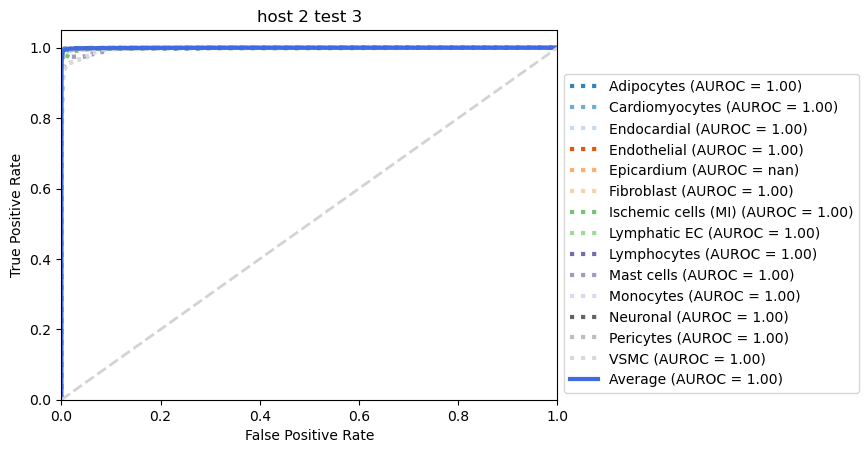

/home/zd775156/anaconda3/envs/sclabel/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/home/zd775156/anaconda3/envs/sclabel/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/zd775156/anaconda3/envs/sclabel/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/zd775156/anaconda3/envs/sclabel/lib/python3.11/site-packages/seaborn/_oldcore.py:149

<Figure size 640x480 with 0 Axes>

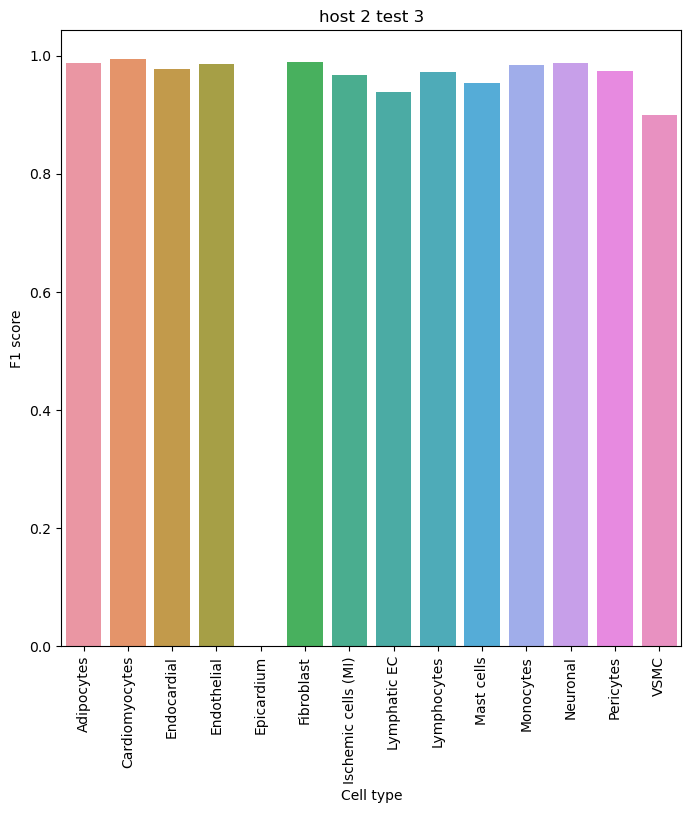

<Figure size 640x480 with 0 Axes>

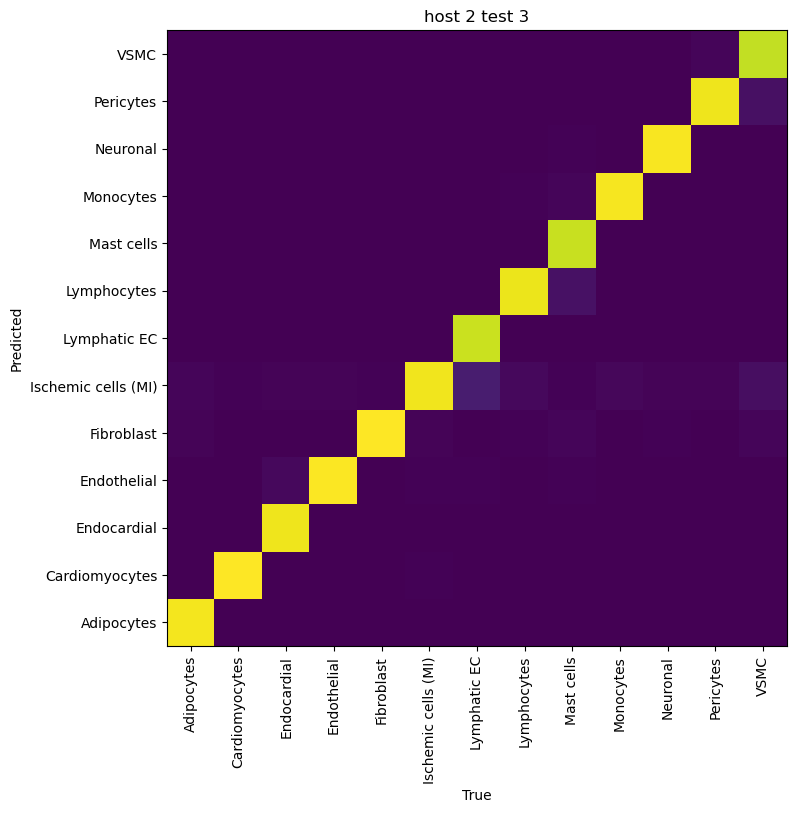

<Figure size 640x480 with 0 Axes>

In [57]:
main(X_train_tensor, y_train_tensor, X_train_tensor, y_train_tensor,f'host {host_id} test {exp_id}', batch_size=500)